# ReadtheDocs Retrieval Augmented Generation (RAG)

In this notebook, we are going to use Milvus documentation pages to create a chatbot about our product.  The chatbot is going to follow RAG steps to retrieve chunks of data using Semantic Vector Search, then the Question + Context will be fed as a Prompt to a LLM to generate an answer.

Many RAG demos use OpenAI for the Embedding Model and ChatGPT for the Generative AI model.  **In this notebook, we will demo a fully open source RAG stack.**

Using open-source Q&A with retrieval saves money since we make free calls to our own data almost all the time - retrieval, evaluation, and development iterations.

<div>
<img src="../images/rag_image.png" width="80%"/>
</div>

Let's get started!

In [1]:
# For colab install these libraries in this order:
# !python -m pip install torch transformers sentence-transformers langchain
# !python -m pip install -U pymilvus
# !python -m pip install unstructured openai tqdm numpy ipykernel 
# !python -m pip install ragas datasets

In [2]:
# Import common libraries.
import sys, os, time, pprint

In [3]:
# Function to remove newlines and double spaces from a string.
def clean_text(text):
    clean_text = text.replace("\n\n", " ")\
                     .replace("\n", " ")\
                     .replace("<br><br>", " ")\
                     .replace("<br /><br />", " ")
    
    # Remove extra whitespace.
    clean_text = ' '.join(clean_text.split())
    return clean_text

import numpy as np
import matplotlib.pyplot as plt

# Function to inspect chunk lengths in matplotlit.
def plot_chunk_lengths(chunked_docs, title_keyword):
    # Get chunk lengths.
    lengths = [len(doc.page_content) for doc in chunked_docs]

    # Mean, median lengths.
    mean_length = np.mean(lengths)
    median_length = np.median(lengths)

    # Assemble the title.
    title = f"Chunk Lengths from {title_keyword} Chunking"

    # Plot the lengths.
    plt.figure(figsize=(10, 6))  # Adjust figure size
    plt.plot(lengths, marker='o')  # Plot lengths with circle markers
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel('Document Index')  # X-axis label
    plt.ylabel('Length')  # Y-axis label
    plt.grid(True)  # Show grid

    # Add a horizontal line at mean and median length
    plt.axhline(y=mean_length, color='g', linestyle='-')
    plt.axhline(y=median_length, color='r', linestyle='-')
    plt.text(len(lengths)-1, mean_length, f'mean = {mean_length:.0f}', va='center', ha='left', backgroundcolor='w', fontsize=12)
    plt.text(0, median_length, f'median = {median_length:.0f}', va='center', ha='right', backgroundcolor='w', fontsize=12)

    plt.show()  # Display the plot

## Download Data

The data used in this notebook is Milvus documentation web pages.

The code block below downloads all the web pages into a local directory called `rtdocs`.  

I've already uploaded the `rtdocs` data folder to github, so you should see it if you cloned my repo.

In [4]:
# # UNCOMMENT TO DOWNLOAD THE DOCS.

# # !pip install -U langchain
# from langchain_community.document_loaders import RecursiveUrlLoader

# DOCS_PAGE="https://milvus.io/docs/"

# loader = RecursiveUrlLoader(DOCS_PAGE)
# docs = loader.load()

# num_documents = len(docs)
# print(f"loaded {num_documents} documents")

# # # Subset docs for faster testing
# # docs = docs[5:7].copy()
# # num_documents = len(docs)
# # print(f"testing with {num_documents} documents")

# # Print the type of the docs.
# print(type(docs))
# print(type(docs[0]))

# docs[0].page_content[:500]

# # UNCOMMENT TO SAVE THE DOCS LOCALLY.
# OUTPUT_DIR = "../../RAG/rtdocs_new/"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # Convert each doc to HTML and save to the specified directory
# for doc in docs:
#     # Extract file name
#     filename = doc.metadata['source'].split('/')[-1].replace(".md", ".html")
    
#     # Check that filename is not empty
#     if filename:
#         with open(os.path.join(OUTPUT_DIR, filename), "w") as f:
#             f.write(doc.page_content)
#     else:
#         print("Filename is empty. Skipping this doc.")
#         pprint.pprint(doc.metadata)
#         pprint.pprint(doc.page_content[:500])

In [5]:
# From raw docs

# UNCOMMENT TO READ THE DOCS FROM A LOCAL DIRECTORY.

# Read docs into LangChain
# !pip install -U langchain
# !pip install unstructured
from langchain.document_loaders import DirectoryLoader

# Load HTML files from a local directory
path = "rtdocs_new/"
global_pattern = '*.html'
loader = DirectoryLoader(path=path, glob=global_pattern)
docs = loader.load()

num_documents = len(docs)
print(f"loaded {num_documents} documents")

# # Subset docs for faster testing
# docs = docs[5:7].copy()
# num_documents = len(docs)
# print(f"testing with {num_documents} documents")

# Inspect type of the docs and texts.
# print(type(docs))
# print(type(docs[0]))
# print(docs[0].page_content[:500])

# Clean up \n literals and source metdata.
for doc in docs:
    doc.page_content = clean_text(doc.page_content)
    doc.metadata["source"] = \
        doc.metadata["source"]\
            .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")
    
print(docs[0].page_content[:500])
pprint.pprint(docs[0].metadata)

loaded 22 documents
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall MilvusInstall SDKsQuickstart Concepts User Guide Models Administration Guide Tools Integrations Example Applications FAQs API reference Quickstart This guide explains how to connect to your Milvus cluster and performs CRUD operations in minutes Before you start You have installed Milvus standalone or Milvus cluster. You have installed preferred SDKs. You c
{'source': 'rtdocs_new/quickstart.md'}


In [6]:
# List every unique source in docs.
doc_sources = set([doc.metadata['source'] for doc in docs])
print(len(doc_sources))
doc_sources

22


{'rtdocs_new/architecture_overview.md',
 'rtdocs_new/aws.md',
 'rtdocs_new/configure-docker.md',
 'rtdocs_new/deploy_s3.md',
 'rtdocs_new/embeddings.md',
 'rtdocs_new/get-and-scalar-query.md',
 'rtdocs_new/glossary.md',
 'rtdocs_new/gpu_index.md',
 'rtdocs_new/index-vector-fields.md',
 'rtdocs_new/index.md',
 'rtdocs_new/insert-update-delete.md',
 'rtdocs_new/install_standalone-docker.md',
 'rtdocs_new/manage-collections.md',
 'rtdocs_new/metric.md',
 'rtdocs_new/milvus-cdc-overview.md',
 'rtdocs_new/monitor_overview.md',
 'rtdocs_new/multi-vector-search.md',
 'rtdocs_new/quickstart.md',
 'rtdocs_new/rbac.md',
 'rtdocs_new/scaleout.md',
 'rtdocs_new/single-vector-search.md',
 'rtdocs_new/system_configuration.md'}

## Load the Embedding Model checkpoint and use it to create vector embeddings

#### What are Embeddings?

Check out [this blog](https://zilliz.com/glossary/vector-embeddings) for an introduction to embeddings.  

An excellent place to start is by selecting an embedding model from the [HuggingFace MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard), sorted descending by the "Retrieval Average'' column since this task is most relevant to RAG. Then, choose the smallest, highest-ranking embedding model. But, Beware!! some models listed are overfit to the training data, so they won't perform on your data as promised.  

Milvus (and Zilliz) only supports tested embedding models that are **not overfit**!

### Use open source Embedding Model from HuggingFace

In [7]:
# !python -m pip install --upgrade langchain_huggingface

In [8]:
# from langchain_huggingface import HuggingFaceEmbeddings

# # Use an embedding model.
# model_name = "BAAI/bge-large-en-v1.5"
# model_kwargs = {'device': 'cpu'}
# encode_kwargs = {'normalize_embeddings': True}
# embed_model = HuggingFaceEmbeddings(
#     model_name=model_name,
#     model_kwargs=model_kwargs,
#     encode_kwargs=encode_kwargs
# )
# EMBEDDING_DIM = embed_model.dict()['client'].get_sentence_embedding_dimension()
# print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

### Use OpenAI Embedding model

In [9]:
# !python -m pip install --upgrade langchain_openai

In [10]:
from langchain_openai.embeddings import OpenAIEmbeddings

# 1. Get your API key: https://platform.openai.com/api-keys
# 2. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety

# 3. OpenAI embedding model name, `text-embedding-3-large` or `ext-embedding-3-small`.
# release notes: https://openai.com/index/new-embedding-models-and-api-updates/
model_name = "text-embedding-3-small"
EMBEDDING_DIM = 512

embed_model = OpenAIEmbeddings(
    model=model_name,
    dimensions=EMBEDDING_DIM,
)
print(f"MODEL: {model_name}, EMBEDDING_DIM: {EMBEDDING_DIM}")

MODEL: text-embedding-3-small, EMBEDDING_DIM: 512


## Setup LLM for Answer Generation (G-part of RAG)

In [11]:
# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

In [12]:
from langchain.prompts import PromptTemplate

prompt_template = """First, check if the provided Context is relevant to 
the user's question.  Second, only if the provided Context is strongly relevant, 
answer the question using the Context.  Otherwise, if the Context is not 
strongly relevant, answer the question without using the Context.  
Be clear, concise, relevant.  Answer clearly, in fewer than 2 sentences.
User's question: {question}
provided Context: {context}
"""
print(f"Length prompt: {len(prompt_template)}")

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["question", "context"]
)

Length prompt: 406


In [13]:
# !python -m pip install -U langchain_openai
from langchain_openai import ChatOpenAI

# Define the generation llm model to use.
# https://openai.com/blog/new-embedding-models-and-api-updates
# Customers using the pinned gpt-3.5-turbo model alias will be automatically upgraded to gpt-3.5-turbo-0125 two weeks after this model launches.
LLM_NAME = "gpt-3.5-turbo"
llm = ChatOpenAI(
    model=LLM_NAME,
    api_key=os.environ.get("OPENAI_API_KEY"),
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY
)

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(
/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! frequency_penalty is not default parameter.
                frequency_penalty was transferred to model_kwargs.
                Please confirm that frequency_penalty is what you intended.
  warnings.warn(


In [14]:
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser

# Define a function to format documents into context text
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def execute_rag_chain(sample_retriever, sample_llm, sample_question):

    # Define the RAG chain for generating answers with the LLM
    rag_chain_from_docs = (
        RunnablePassthrough.assign(context=lambda x: format_docs(x["context"]))
        | PROMPT
        | sample_llm
        | StrOutputParser()
    )

    # Define the chain that handles retrieval and combines with the LLM response
    sample_rag_chain = RunnableParallel({
            "context": sample_retriever, 
            "question": RunnablePassthrough()
        }).assign(answer=rag_chain_from_docs)

    # Invoke the chain with the sample question.
    results = sample_rag_chain.invoke(sample_question)

    # Extract the answer
    print("Answer:", results["answer"])

    # Extract unique sources from the context metadata.
    unique_sources = []
    for context in results["context"]:
        source = context.metadata['source']
        if source not in unique_sources:
            unique_sources.append(source)
    print(f"Sources: {unique_sources}")

## Define 4 questions

Search Milvus using [PyMilvus API](https://milvus.io/docs/search.md).

💡 By their nature, vector searches are "semantic" searches.  For example, if you were to search for "leaky faucet": 
> **Traditional Key-word Search** - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.

> **Semantic search** - results containing words "drippy" "taps" would be returned as well because these words mean the same thing even though they are different words.


In [15]:
# Define a sample question about your data.
QUESTION1 = "What do the parameters for HNSW mean?"
QUESTION2 = "What are good default values for HNSW parameters with 25K vectors dim 1024?"
QUESTION3 = "What does nlist vs nprobe mean in ivf_flat?"
QUESTION4 = "What is the default AUTOINDEX index and vector field distance metric in Milvus?"

# In case you want to ask all the questions at once.
QUERY = [QUESTION1, QUESTION2, QUESTION3, QUESTION4]

# Inspect the length of one question.
QUERY_LENGTH = len(QUESTION2)
print(f"example query length: {QUERY_LENGTH}")

example query length: 75


## Small-to-big Chunking

In [16]:
# !python -m pip install lxml
from langchain_milvus import Milvus
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
import time, pprint

chunk_size: 512, chunk_overlap: 51.0
22 docs split into 355 child documents.


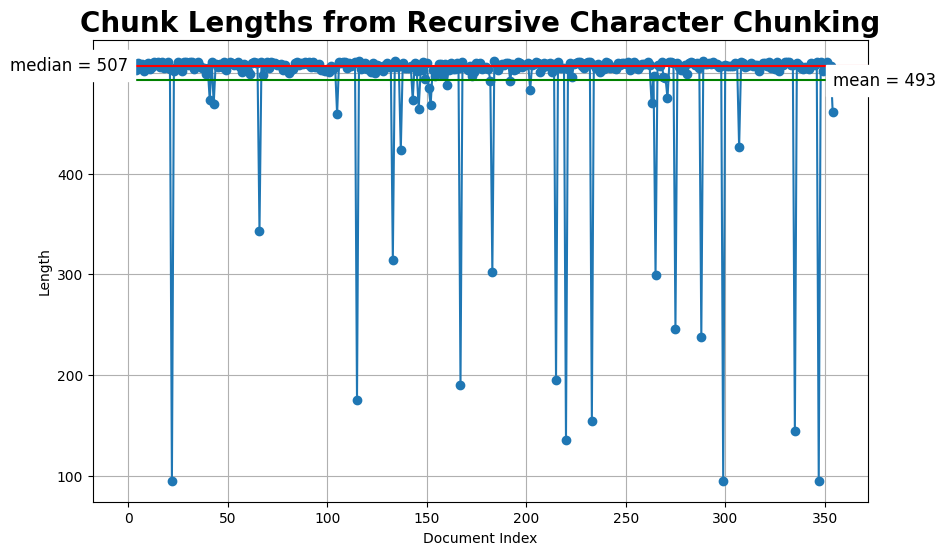

In [17]:
CHUNK_SIZE = 512
chunk_overlap = np.round(CHUNK_SIZE * 0.10, 0)
print(f"chunk_size: {CHUNK_SIZE}, chunk_overlap: {chunk_overlap}")

# The splitter to create smaller (child) chunks
# Default splitters: https://github.com/langchain-ai/langchain/blob/9ef2feb6747f5a69d186bd623b569ad722829a5e/libs/langchain/langchain/text_splitter.py#L842
child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE, 
    chunk_overlap=chunk_overlap,
    # length_function = len,  # use built-in Python len function
    # separators = ["\n\n", "\n", " ", ". ", ""], # defaults
)

# Child docs for inspection
sub_docs = child_splitter.split_documents(docs)
print(f"{len(docs)} docs split into {len(sub_docs)} child documents.")

# Inspect chunk lengths
plot_chunk_lengths(sub_docs, 'Recursive Character')

chunk_size: 1586
22 docs split into 124 parent documents.


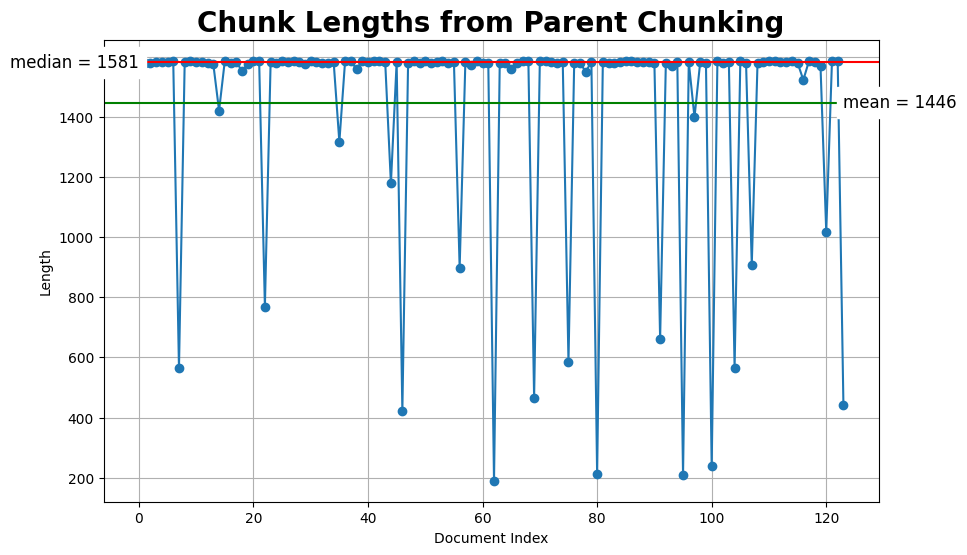

In [18]:
PARENT_CHUNK_SIZE = 1586
print(f"chunk_size: {PARENT_CHUNK_SIZE}")

# The splitter to use to create bigger (parent) chunks
parent_splitter = RecursiveCharacterTextSplitter(
    chunk_size=PARENT_CHUNK_SIZE,
)

# Parent docs for inspection.
parent_docs = parent_splitter.split_documents(docs)
print(f"{len(docs)} docs split into {len(parent_docs)} parent documents.")

# Inspect chunk lengths
plot_chunk_lengths(parent_docs, 'Parent')

In [19]:
# Drop the existing vectorstore if it exists.
try:
    del vectorstore
except:
    pass

# Create vectorstore for vector indexing and retrieval.
COLLECTION_NAME = "MilvusDocs"
vectorstore = Milvus(
    collection_name=COLLECTION_NAME,
    embedding_function=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    auto_id=True,
    # Set to True to drop the existing collection if it exists.
    drop_old=True,
)

# Create doc storage for the parent documents.
store = InMemoryStore()

# Create the ParentDocumentRetriever.
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore, 
    docstore=store, 
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
)

In [20]:
# When we add documents two things will happen:
# Parent chunks - docs split into large chunks.
# Child chunks - docs split into into smaller chunks.
# Relationship between parent and child is kept.
retriever.add_documents(docs, ids=None)

In [21]:
# Check how many parent docs are in the doc store.
len(list(store.yield_keys()))

124

#### Test with questions

In [22]:
# SELECT A PARTICULAR QUESTION TO ASK.
SAMPLE_QUESTION = QUESTION4

In [23]:
# The vector store alone will retrieve small chunks:
TOP_K = 2
child_results = vectorstore.similarity_search(
    SAMPLE_QUESTION,
    k=TOP_K)

print(f"Question: {SAMPLE_QUESTION}")

# Print the retrieved chunk and metadata.
# Append each unique context and source to a list.
contexts = []
sources = []
for i, child_result in enumerate(child_results):
    context = child_result.page_content
    print(f"Result #{i+1}, len: {len(context)}")
    print(f"chunk: {context}")
    pprint.pprint(f"metadata: {child_result.metadata}")
    context = child_result.page_content
    contexts.append(context)
    source = child_result.metadata['source']
    if source not in sources:
        sources.append(source)

print(f"sources: {len(sources)}, {sources}")

Question: What is the default AUTOINDEX index and vector field distance metric in Milvus?
Result #1, len: 509
chunk: True, and auto_id is enabled for the primary key. Additionally, a vector field is introduced, configured with a dimensionality of 768, along with the inclusion of four scalar fields, each with its respective attributes. Step 2: Set up index parameters Index parameters dictate how Milvus organizes your data within a collection. You can tailor the indexing process for specific fields by adjusting their metric_type and index_type. For the vector field, you have the flexibility to select COSINE, L2, or IP as
("metadata: {'source': 'rtdocs_new/manage-collections.md', 'doc_id': "
 "'fdc85d86-4cba-4cdd-aa4d-6af8eacdb82b', 'pk': 451032861719396419}")
Result #2, len: 506
chunk: walks you through the basic operations on creating and managing indexes on vector fields in a collection. Overview Leveraging the metadata stored in an index file, Milvus organizes your data in a specializ

In [24]:
# Whereas the doc retriever will return the larger parent document:
parent_results = retriever.get_relevant_documents(SAMPLE_QUESTION)

# Print the retrieved chunk and metadata.
print(f"Num parent results: {len(parent_results)}")
for i, parent_result in enumerate(parent_results):
    print(f"Result #{i+1}, len: {len(parent_result.page_content)}")
    print(f"chunk: {parent_result.page_content}")
    pprint.pprint(f"metadata: {parent_result.metadata}")

assert parent_results[0].metadata['source'] == sources[0]

Num parent results: 4
Result #1, len: 1583
chunk: vector in the data to be inserted, are treated as dynamic fields. These additional fields are saved as key-value pairs within a special field named $meta. This feature allows the inclusion of extra fields during data insertion. The automatically indexed and loaded collection from the provided code is ready for immediate data insertions. Customized setup Instead of letting Milvus decide almost everything for your collection, you can determine the schema and index parameters of the collection on your own. Step 1: Set up schema A schema defines the structure of a collection. Within the schema, you have the option to enable or disable enable_dynamic_field, add pre-defined fields, and set attributes for each field. For a detailed explanation of the concept and available data types, refer to Schema Explained. Python Java Node.js In the provided code snippet for Python, the enable_dynamic_field is set to True, and auto_id is enabled for the pr

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [25]:
# Separate all the context together by space.
contexts_combined = ' '.join(contexts)
# Lance Martin, LangChain, says put best contexts at end.
contexts_combined = ' '.join(reversed(contexts))

# Separate all the unique sources together by comma.
source_combined = ' '.join(reversed(list(dict.fromkeys(sources))))

# Alternatively use the parent (bigger) chunks.
contexts_combined = parent_results[0].page_content
source_combined = sources[0]
print(f"sources: {source_combined}")

print(f"Length long text to summarize: {len(contexts_combined)}")

sources: rtdocs_new/manage-collections.md
Length long text to summarize: 1583


In [26]:
# Delete the Milvus collection and doc store.
# del vectorstore, retriever, store

## Semantic Chunking

This chunker works by determining when to "break" apart sentences. This is done by calculating cosine distances between adjacent sentences. Looking across all these cosine distances, look for outlier distances past some threshold.  These outlier distances determine when chunks are split.

There are a few ways to determine what that threshold is, which are controlled by the breakpoint_threshold_type kwarg.

- `percentile` (default) — In this method, any distances greater than X percentile is split into a chunk.

- `standard_deviation` — In this method, any difference greater than X standard deviations is split.

- `interquartile` — In this method, the interquartile distance is used to split chunks.

- See Semantic Chunking [docs](https://python.langchain.com/v0.2/docs/how_to/semantic-chunker/#standard-deviation) and [api](https://api.python.langchain.com/en/latest/text_splitter/langchain_experimental.text_splitter.SemanticChunker.html).

In [27]:
# !python -m pip install langchain_experimental

Created 87 semantic documents from 22 in 24.78 seconds
('Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus '
 'FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall '
 'MilvusInstall SDKsQuickstart Concepts User Guide Models Ad')
{}


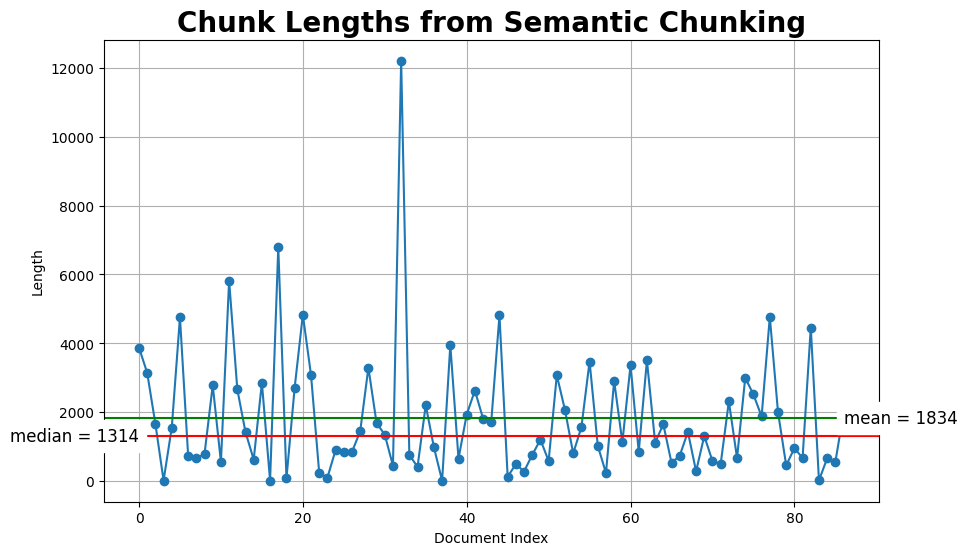

In [28]:
from langchain_experimental.text_splitter import SemanticChunker

# Initialize the SemanticChunker with the embedding model.
semantic_text_splitter = SemanticChunker(embed_model)

semantic_docs = []
start_time = time.time()
for doc in docs:

    # Split the doc into semantic chunks.
    semantic_list = semantic_text_splitter.create_documents([doc.page_content])

    # Append the list of semantic chunks to semantic_docs.
    semantic_docs.extend(semantic_list)

end_time = time.time()

# Inspect chunk lengths
print(f"Created {len(semantic_docs)} semantic documents from {len(docs)} in {end_time - start_time:.2f} seconds")
pprint.pprint(semantic_docs[0].page_content[:200])
pprint.pprint(semantic_docs[0].metadata)
# Created 87 semantic documents from 22.

# Inspect chunk lengths
plot_chunk_lengths(semantic_docs, 'Semantic')

In [29]:
# # Use Percentile to determine breakpoints.
# text_splitter = SemanticChunker(
#     embed_model, 
#     breakpoint_threshold_type="percentile",
#     breakpoint_threshold_amount=0.99
# )

# semantic_docs = text_splitter.create_documents([all_page_contents])
# print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")

# # Too many!
# # Created 1138 semantic documents from 22.

In [30]:
# # Use Standard Deviation to determine breakpoints.
# text_splitter = SemanticChunker(
#     embed_model, 
#     breakpoint_threshold_type="standard_deviation",
#     breakpoint_threshold_amount=0.80
# )
# semantic_docs = text_splitter.create_documents([all_page_contents])

# print(f"Created {len(semantic_docs)} semantic documents from {len(docs)}.")
# print(", ".join(str(len(doc.page_content)) for doc in semantic_docs))
# pprint.pprint(semantic_docs[0].page_content)

# # Created 195 semantic documents from 22.

In [31]:
# Drop vectorstore if it exists.
try:
    del vectorstore
except:
    pass

# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"
start_time = time.time()
vectorstore = Milvus.from_documents(
    collection_name=COLLECTION_NAME,
    documents=semantic_docs,
    embedding=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    # Override LangChain default values for Milvus.
    consistency_level="Eventually",
    # auto_id=True,
    drop_old=True,
    index_params = {
        "metric_type": "COSINE",
        "index_type": "AUTOINDEX",
        "params": {},}
)
end_time = time.time()
print(f"Created Milvus collection from {len(semantic_docs)} docs in {end_time - start_time:.2f} seconds")

Created Milvus collection from 87 docs in 3.18 seconds


#### Test with questions

In [32]:
# SELECT A PARTICULAR QUESTION TO ASK.
SAMPLE_QUESTION = QUESTION3

In [33]:
# Retrieve semantic chunks.
TOP_K = 2
semantic_retriever = vectorstore.as_retriever(search_kwargs={"k" : TOP_K})
semantic_results = semantic_retriever.invoke(SAMPLE_QUESTION)

print(f"Question: {SAMPLE_QUESTION}")

# Print the retrieved chunk and metadata.
contexts = []
# sources = []
for i, semantic_result in enumerate(semantic_results):
    context = semantic_result.page_content
    print(f"Result #{i+1}, len: {len(context)}")
    print(f"chunk: {context}")
    pprint.pprint(f"metadata: {semantic_result.metadata}")

    # Keep a copy of all the contexts and sources.
    contexts.append(context)
    # source = semantic_result.metadata['source']
    # if source not in sources:
    #     sources.append(source)

Question: What does nlist vs nprobe mean in ivf_flat?
Result #1, len: 4834
chunk: By adjusting nprobe, an ideal balance between accuracy and speed can be found for a given scenario. Query time increases sharply as both the number of target input vectors (nq), and the number of clusters to search (nprobe), increase. BIN_IVF_FLAT is the most basic BIN_IVF index, and the encoded data stored in each unit is consistent with the original data. Index building parameters Parameter Description Range nlist Number of cluster units [1, 65536] Search parameters Common search Parameter Description Range Default Value nprobe Number of units to query [1, nlist] 8 Range search Parameter Description Range Default Value max_empty_result_buckets Maximum number of buckets not returning any search results.This is a range-search parameter and terminates the search process whilst the number of consecutive empty buckets reaches the specified value.Increasing this value can improve recall rate at the cost of in

In [34]:
# Separate all the context together by space.
contexts_combined = ' '.join(contexts)

print(f"Length long text to summarize: {len(contexts_combined)}")
contexts_combined

Length long text to summarize: 11629


"By adjusting nprobe, an ideal balance between accuracy and speed can be found for a given scenario. Query time increases sharply as both the number of target input vectors (nq), and the number of clusters to search (nprobe), increase. BIN_IVF_FLAT is the most basic BIN_IVF index, and the encoded data stored in each unit is consistent with the original data. Index building parameters Parameter Description Range nlist Number of cluster units [1, 65536] Search parameters Common search Parameter Description Range Default Value nprobe Number of units to query [1, nlist] 8 Range search Parameter Description Range Default Value max_empty_result_buckets Maximum number of buckets not returning any search results.This is a range-search parameter and terminates the search process whilst the number of consecutive empty buckets reaches the specified value.Increasing this value can improve recall rate at the cost of increased search time. [1, 65535] 2 SPARSE_INVERTED_INDEX Each dimension maintains 

In [35]:
# Delete the Milvus collection and vectorstore.
# del vectorstore

## HTML Chunking using LangChain

Before embedding, it is necessary to decide your chunk strategy, chunk size, and chunk overlap.  This section uses:
- **Strategy** = Use markdown header hierarchies.  Keep markdown sections together unless they are too long.
- **Chunk size** = Use the embedding model's parameter `MAX_SEQ_LENGTH`
- **Overlap** = Rule-of-thumb 10-15%
- **Function** = 
  - Langchain's `HTMLHeaderTextSplitter` to split markdown sections.
  - Langchain's `RecursiveCharacterTextSplitter` to split up long reviews recursively.


Notice below, each chunk is grounded with the document source page.  <br>
In addition, header titles are kept together with the chunk of markdown text.

In [36]:
# DOWNLOAD THE DOCS.

# !pip install -U langchain
from langchain_community.document_loaders import RecursiveUrlLoader

DOCS_PAGE="https://milvus.io/docs/"

loader = RecursiveUrlLoader(DOCS_PAGE)
raw_html_docs = loader.load()
# Drop 0th doc due to empty content.
raw_html_docs = raw_html_docs[1:]

num_documents = len(raw_html_docs)
print(f"loaded {num_documents} documents")

# # Subset docs for faster testing
# raw_html_docs = raw_html_docs[5:7].copy()
# num_documents = len(raw_html_docs)
# print(f"testing with {num_documents} documents")

# Clean up \n literals and source metdata.
for doc in raw_html_docs:
    doc.page_content = clean_text(doc.page_content)
    doc.metadata["source"] = \
        doc.metadata["source"]\
            .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
            .replace(".html", ".md")

# Print the type of the docs.
print(type(raw_html_docs))
print(type(raw_html_docs[0]))

# Check the raw HTML docs.
print(raw_html_docs[0].page_content[:500])
pprint.pprint(raw_html_docs[0].metadata)

loaded 22 documents
<class 'list'>
<class 'langchain_core.documents.base.Document'>
<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><link rel="icon" href="/favicon-32x32.png"/><meta name="image" property="og:image" content="https://assets.zilliz.com/meta_image_milvus_d6510e10e0.png"/><meta property="og:type" content="WebSite"/><title>Run Milvus in Docker | Milvus Documentation</title><meta name="description" content="Learn how to install Milvus standalone with Docker. | v2.4.x"/><meta property="og:title" content="R
{'content_type': 'text/html',
 'description': 'Learn how to install Milvus standalone with Docker. | v2.4.x',
 'language': 'en',
 'source': 'https://milvus.io/docs/install_standalone-docker.md',
 'title': 'Run Milvus in Docker | Milvus Documentation'}


In [37]:
# Check the raw docs again.
print(raw_html_docs[0].page_content[:500])
pprint.pprint(raw_html_docs[0].metadata)

<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><link rel="icon" href="/favicon-32x32.png"/><meta name="image" property="og:image" content="https://assets.zilliz.com/meta_image_milvus_d6510e10e0.png"/><meta property="og:type" content="WebSite"/><title>Run Milvus in Docker | Milvus Documentation</title><meta name="description" content="Learn how to install Milvus standalone with Docker. | v2.4.x"/><meta property="og:title" content="R
{'content_type': 'text/html',
 'description': 'Learn how to install Milvus standalone with Docker. | v2.4.x',
 'language': 'en',
 'source': 'https://milvus.io/docs/install_standalone-docker.md',
 'title': 'Run Milvus in Docker | Milvus Documentation'}


In [38]:
# List every unique source in raw_html_docs.
raw_html_doc_sources = set([doc.metadata['source'] for doc in raw_html_docs])
print(len(raw_html_doc_sources))
raw_html_doc_sources

22


{'https://milvus.io/docs/architecture_overview.md',
 'https://milvus.io/docs/aws.md',
 'https://milvus.io/docs/configure-docker.md',
 'https://milvus.io/docs/deploy_s3.md',
 'https://milvus.io/docs/embeddings.md',
 'https://milvus.io/docs/get-and-scalar-query.md',
 'https://milvus.io/docs/glossary.md',
 'https://milvus.io/docs/gpu_index.md',
 'https://milvus.io/docs/index-vector-fields.md',
 'https://milvus.io/docs/index.md',
 'https://milvus.io/docs/insert-update-delete.md',
 'https://milvus.io/docs/install_standalone-docker.md',
 'https://milvus.io/docs/manage-collections.md',
 'https://milvus.io/docs/metric.md',
 'https://milvus.io/docs/milvus-cdc-overview.md',
 'https://milvus.io/docs/monitor_overview.md',
 'https://milvus.io/docs/multi-vector-search.md',
 'https://milvus.io/docs/quickstart.md',
 'https://milvus.io/docs/rbac.md',
 'https://milvus.io/docs/scaleout.md',
 'https://milvus.io/docs/single-vector-search.md',
 'https://milvus.io/docs/system_configuration.md'}

In [39]:
# !python -m pip install lxml
from langchain.text_splitter import HTMLHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain_core.documents.base import Document
import uuid, re, html

doc_ids = [str(uuid.uuid4()) for _ in raw_html_docs]

# Define the headers to split on for the HTMLHeaderTextSplitter
headers_to_split_on = [
    ("<h1>", "Header 1"),
    ("<h2>", "Header 2"),
    ("<h3>", "Header 3"),
]
# Create an instance of the HTMLHeaderTextSplitter
html_splitter = HTMLHeaderTextSplitter(
    headers_to_split_on,
    # Return each element together with their associated headers
    return_each_element=True,
)

# TODO: Clean up this SCRATCH code later.
# Milvus docs don't have simple h1, h2, h3 tags.
# Construct a regex pattern to match any of the specified headers.
pattern = r"<h[1-3][^>]*>"
print("Pattern for splitting:", pattern)

# Function to remove all HTML tags
def remove_html_tags(text):
    return re.sub(r"<[^>]+>", "", text)
def remove_extra_spaces(text):
    # Replace three or more spaces with a single space
    return re.sub(r' {3,}', ' ', text)
def remove_html_markup(text):
    # Pattern to match opening and closing tags, including attributes within the tags
    pattern = r"<[^>]+>.*?</[^>]+>"
    clean_text = re.sub(pattern, "", text)
    pattern = r"<[^>]+>"
    clean_text = re.sub(pattern, "", text)
    return clean_text

# Split the HTML text using the HTMLHeaderTextSplitter.
new_docs = []
for doc_id, html_doc, parsed_doc in zip(doc_ids, raw_html_docs, docs):

    # Grab the headers
    new_text = html_doc.page_content.replace('\n', ' ')
    html_split_list = re.split(pattern, new_text)

    # Remove HTML tags from each extracted header text
    headers_list = [remove_html_tags(header) for header in html_split_list]
    # print(html_split_list[0])
    # print(f"Split into {len(html_split_list)} parts.")

    # Split the text into chunks using the HTMLHeaderTextSplitter.
    # splits = html_splitter.split_text(doc.page_content)
    splits = html_split_list

    for split in splits:
        # Initialize a temp Document object.
        temp = Document(page_content=split)
        temp.page_content = parsed_doc.page_content

        # Assemble the metadata.
        metadata = {}
        # Handle exception if h1 does not exist.
        try:
            header_value1 = headers_list[1].strip().split("  ")[0][:25]
            metadata["h1"] = header_value1
            # print(f"header_name: h1, header_value: {header_value1}")
        except:
            pass
        # Handle exception if h2 does not exist.
        try:
            header_value2 = headers_list[2].strip().split("  ")[0][:25]
            if len(header_value2) <= 0:
                header_value2 = headers_list[3].strip().split("  ")[0][:25]
            metadata["h2"] = header_value2
            # print(f"header_name: h2, header_value: {header_value2}")
        except:
            pass
        # Handle exception if h2 does not exist.
        try:
            header_value3 = headers_list[3].strip().split("  ")[0][:25]
            if (len(header_value3) <= 0 or header_value3 == header_value2):
                header_value3 = headers_list[4].strip().split("  ")[0][:25]
            if header_value3 == header_value2:
                header_value3 = headers_list[5].strip().split("  ")[0][:25]
            metadata["h3"] = header_value3
            # print(f"header_name: h3, header_value: {header_value3}")
        except:
            pass
        temp.metadata = {
            **metadata,
            "source": doc.metadata["source"]\
                .replace("../../RAG/rtdocs_new", "https://milvus.io/docs")\
                .replace(".html", ".md"),
            'doc_index': doc_id
        }

        # Match page content with parsed page content.
        temp.page_content = parsed_doc.page_content
        try:
            start_index = str.find(parsed_doc.page_content, header_value1)
            end_index = str.find(parsed_doc.page_content, header_value2)
            if start_index != -1 and end_index != -1:
                # print("Found h1, h2")
                # print(parsed_doc.page_content[start_index:end_index])
                temp.page_content = parsed_doc.page_content[start_index:end_index]
                temp.page_content = remove_html_markup(temp.page_content).replace('\n', ' ')
                temp.page_content = remove_extra_spaces(temp.page_content).strip()
        except:
            pass
        try:
            start_index = str.find(parsed_doc.page_content, header_value2)
            end_index = str.find(parsed_doc.page_content, header_value3)
            if start_index != -1 and end_index != -1:
                temp.page_content = parsed_doc.page_content[start_index:end_index]
                temp.page_content = remove_html_markup(temp.page_content).replace('\n', ' ')
                temp.page_content = remove_extra_spaces(temp.page_content).strip()
            # print("Found h2, h3")
        except:
            pass
        try:
            start_index = str.find(parsed_doc.page_content, header_value3)
            if start_index != -1:
                temp.page_content = parsed_doc.page_content[start_index:]
                temp.page_content = remove_html_markup(temp.page_content).replace('\n', ' ')
                temp.page_content = remove_extra_spaces(temp.page_content).strip()
            # print("Found h3")
        except:
            pass

    new_docs.extend(temp)

html_docs = []
for content in new_docs:
    # Assuming each 'content' is a tuple or list with [page_content, metadata]
    page_content, metadata = content  # This line unpacks the tuple or list

    # Ensure page_content is a string
    if isinstance(metadata, str) and metadata != "Document":
        html_doc = Document(page_content=metadata)
    elif isinstance(metadata, dict):
        html_doc.metadata = metadata
    else:
        pass

    html_docs.append(html_doc)

# Inspect chunk lengths
print(f"docs: {len(docs)}, split into {len(html_docs)} html chunks.")
print(html_docs[0].page_content[:200])
print(html_docs[0].metadata)

Pattern for splitting: <h[1-3][^>]*>
docs: 22, split into 66 html chunks.
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get StartedPrerequisitesInstall MilvusInstall SDKsQuickstart Concepts User Guide Models Ad
{'h1': 'Run Milvus in Docker', 'h2': 'Prerequisites', 'h3': 'Install Milvus in Docker', 'source': 'https://milvus.io/docs/embeddings.md', 'doc_index': '94964a79-ecd2-4783-932d-e00b8d638975'}


In [40]:
print(len(html_docs), type(html_docs[0]))
print(html_docs[65].page_content)
print(html_docs[65].metadata)

66 <class 'langchain_core.documents.base.Document'>
Why Milvus Docs Tutorials Tools Blog Community Stars0 Try Managed Milvus FREE Search Home v2.4.x About Milvus Get Started Concepts User Guide Models Administration GuideDeploymentConfigurationManage DependenciesWith Docker or HelmObject StorageMeta StorageMessage StorageWith Milvus OperatorScalingUpgradeMonitoring, Alerts & LogsSecurity Tools Integrations Example Applications FAQs API reference Configure Object Storage with Docker Compose or Helm Milvus uses MinIO for object storage by default, but it also supports using Amazon Simple Storage Service (S3) as persistent object storage for log and index files. This topic describes how to configure S3 for Milvus. You can skip this topic if you are satisfied with MinIO. You can configure S3 with Docker Compose or on K8s. Configure S3 with Docker Compose 1. Configure S3 MinIO is compatible with S3. To configure S3 with Docker Compose, provide your values for the minio section in the milvus

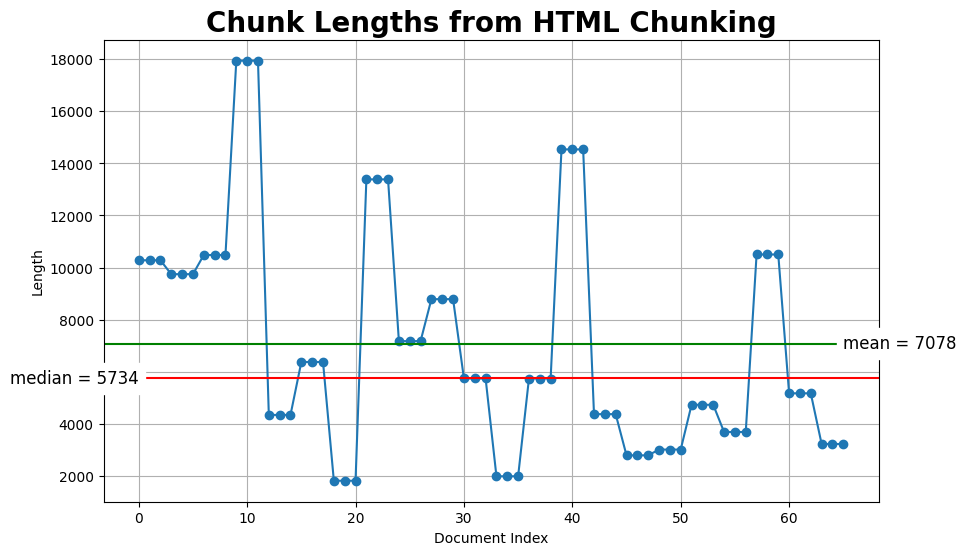

In [41]:
# Inspect chunk lengths
plot_chunk_lengths(html_docs, 'HTML')

In [42]:
# Split html chunks into child chunks
html_sub_docs = child_splitter.split_documents(html_docs)
print(f"docs: {len(html_docs)}, split into {len(html_sub_docs)} html sub chunks.")

docs: 66, split into 1038 html sub chunks.


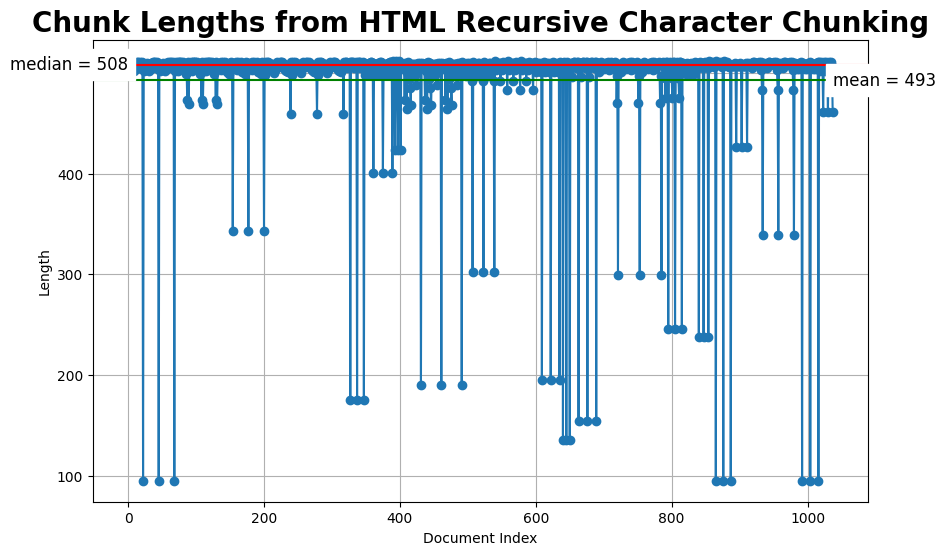

In [43]:
# Inspect chunk lengths
plot_chunk_lengths(html_sub_docs, 'HTML Recursive Character')

In [44]:
# Drop the existing vectorstore if it exists.
try:
    del vectorstore
except:
    pass

# Create vectorstore for vector index and retrieval.
COLLECTION_NAME = "MilvusDocs"

# Create vectorstore for vector index and retrieval.
vectorstore = Milvus(
    collection_name=COLLECTION_NAME,
    embedding_function=embed_model,
    connection_args={"uri": "./milvus_demo.db"},
    auto_id=True,
    # Set to True to drop the existing collection if it exists.
    drop_old=True,
    index_params = {
        "metric_type": "COSINE",
        "index_type": "AUTOINDEX",
        "params": {},}
)

# Index the documents in the vector store.
batch_size = 600
total_docs = len(html_sub_docs)

# Calculate the number of batches needed
batches = (total_docs + batch_size - 1) // batch_size
start_time = time.time()
for i in range(batches):
    batch_start = i * batch_size
    batch_end = min(batch_start + batch_size, total_docs)
    batch = sub_docs[batch_start:batch_end]
    vectorstore.add_documents(batch)

end_time = time.time()
print(f"Indexed a total of {total_docs} child documents in {time.time()-start_time:.2f} seconds")

Indexed a total of 1038 child documents in 2.83 seconds


#### Test with questions

In [45]:
# SELECT A PARTICULAR QUESTION TO ASK.
SAMPLE_QUESTION = QUESTION4

# The vector store retrieves whichever chunks you indexed:
TOP_K = 2
child_results = vectorstore.similarity_search(
    SAMPLE_QUESTION,
    k=TOP_K)

print(f"Question: {SAMPLE_QUESTION}")

# Print the retrieved chunk and metadata.
# Append each unique context and source to a list.
contexts = []
sources = []
for i, child_result in enumerate(child_results):
    context = child_result.page_content
    print(f"Result #{i+1}, len: {len(context)}")
    print(f"chunk: {context}")
    pprint.pprint(f"metadata: {child_result.metadata}")
    context = child_result.page_content
    contexts.append(context)
    source = child_result.metadata['source']
    if source not in sources:
        sources.append(source)

print(f"sources: {len(sources)}, {sources}")

Question: What is the default AUTOINDEX index and vector field distance metric in Milvus?
Result #1, len: 510
chunk: is set to True, and auto_id is enabled for the primary key. Additionally, a vector field is introduced, configured with a dimensionality of 768, along with the inclusion of four scalar fields, each with its respective attributes. Step 2: Set up index parameters Index parameters dictate how Milvus organizes your data within a collection. You can tailor the indexing process for specific fields by adjusting their metric_type and index_type. For the vector field, you have the flexibility to select COSINE, L2,
("metadata: {'source': 'rtdocs_new/manage-collections.md', 'pk': "
 '451032876104025202}')
Result #2, len: 506
chunk: walks you through the basic operations on creating and managing indexes on vector fields in a collection. Overview Leveraging the metadata stored in an index file, Milvus organizes your data in a specialized structure, facilitating rapid retrieval of req

In [46]:
# Separate all the context together by space.
contexts_combined = ' '.join(contexts)
# Lance Martin, LangChain, says put best contexts at end.
contexts_combined = ' '.join(reversed(contexts))

print(f"Length long text to summarize: {len(contexts_combined)}")

# Separate all the unique sources together by comma.
source_combined = ' '.join(reversed(list(dict.fromkeys(sources))))
print(f"sources: {source_combined}")

Length long text to summarize: 1017
sources: rtdocs_new/index-vector-fields.md rtdocs_new/manage-collections.md


In [47]:
# Delete the Milvus collection and doc store.
# del vectorstore, retriever, store

## Summarize the context using a LLM

Using a small, open source LLM should be good enough for the summarization task.

In [48]:
# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

# Define a system prompt to use for summarization.
SYSTEM_PROMPT = f"""First select the text that is relevant to the 
user's question.  Second, summarize the selected text so it is clear,
easy to understand, and concise, in fewer than 10 sentences.
Text: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")


Length prompt: 1202


In [49]:
# print(SYSTEM_PROMPT)

In [50]:
# !python -m pip install ollama
# !ollama pull llama3
import ollama

# Verify details which model you are running.
ollama_llama3 = ollama.list()['models'][0]

# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama.list()['models'][0]['name']}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][0]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

MODEL:llama3:latest, FORMAT:gguf, PARAMETER_SIZE:8.0B, QUANTIZATION_LEVEL:Q4_0, 



In [51]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model='llama3',
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)
ollama_llama3_time = time.time() - start_time

# Print all answers in the response.
semantic_summary = ""
semantic_summary += response['message']['content'] + " "
print(f"Answer: {semantic_summary}")
print("\n")
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

Answer: According to my previous text selection:

The default `AUTOINDEX` index uses Cosine Similarity (COSINE) as its distance metric. This means that when you create an index on a vector field, it will use the COSINE similarity calculation by default.

Let me know if I can help with anything else! 


ollama_llama3_time: 12.35 seconds


# Use an LLM to Generate a chat response to the user's question using the Retrieved Context.

Many different generative LLMs exist these days.  Check out the lmsys [leaderboard](https://chat.lmsys.org/?leaderboard).

In this notebook, we'll try these LLMs:
- The newly released open-source Llama 3 from Meta.
- The cheapest, paid model from Anthropic Claude3 Haiku.
- The standard in its price cateogory, gpt-3.5-turbo, from Openai.

In [52]:
from langchain.prompts import PromptTemplate

SYSTEM_PROMPT = f"""First, check if the provided Context is relevant to 
the user's question.  Second, only if the provided Context is strongly relevant, 
answer the question using the Context.  Otherwise, if the Context is not 
strongly relevant, answer the question without using the Context.  
Be clear, concise, relevant.  Answer clearly, in fewer than 2 sentences.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")

# Inspect the prompt.
# pprint.pprint(SYSTEM_PROMPT)

Length prompt: 1463


### Try Meta Llama 3 with Ollama to generate a human-like chat response to the user's question

Follow the instructions to install ollama and pull a model.<br>
https://github.com/ollama/ollama

View details about which models are supported by ollama. <br>
https://ollama.com/library/llama3

That page says `ollama run llama3` will by default pull the latest "instruct" model, which is fine-tuned for chat/dialogue use cases.

The other kind of llama3 models are "pre-trained" base model. <br>
Example: ollama run llama3:text ollama run llama3:70b-text

**Format** `gguf` means the model runs on CPU.  gg = "Georgi Gerganov", creator of the C library model format ggml, which was recently changed to gguf.

**Quantization** (think of it like vector compaction) can lead to higher throughput at the expense of lower accuracy.  For the curious, quantization meanings can be found on: <br>
https://huggingface.co/TheBloke/Llama-2-13B-chat-GGML/tree/main.  

Below just listing the main quantization types.
- **q4_0**: Original quant method, 4-bit.
- **q4_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K
- **q5_0**: Higher accuracy, higher resource usage and slower inference.
- **q5_k_m**: Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K
- **q 6_k**: Uses Q8_K for all tensors
- **q8_0**: Almost indistinguishable from float16. High resource use and slow. Not recommended for most users.

In [53]:
# !python -m pip install ollama
# !ollama pull llama3
import ollama

# Verify details which model you are running.
ollama_llama3 = ollama.list()['models'][0]

# Print the model details.
keys = ['format', 'parameter_size', 'quantization_level']
print(f"MODEL:{ollama.list()['models'][0]['name']}", end=", ")
for key in keys:
    print(f"{str.upper(key)}:{ollama.list()['models'][0]['details'].get(key, 'Key not found in dictionary')}", end=", ")
print(end="\n\n")

MODEL:llama3:latest, FORMAT:gguf, PARAMETER_SIZE:8.0B, QUANTIZATION_LEVEL:Q4_0, 



In [54]:
# Send the question to llama 3 chat.
start_time = time.time()
response = ollama.chat(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model='llama3',
    stream=False,
    options={"temperature": TEMPERATURE, "seed": RANDOM_SEED,
             "top_p": TOP_P, 
            #  "max_tokens": MAX_TOKENS,
             "frequency_penalty": FREQUENCY_PENALTY}
)

ollama_llama3_time = time.time() - start_time
print(response['message']['content'])
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

The default AUTOINDEX index type uses Cosine Similarity (COSINE) as its distance metric.
ollama_llama3_time: 1.88 seconds


#### Call the LLM using a LangChain rag_chain pipeline.

In [55]:
# Change the LangChain llm to the llama3 model with Ollama.
from langchain_community.chat_models import ChatOllama
LLM_NAME = 'llama3'
llm=ChatOllama(model=LLM_NAME)

# Child doc, Recursive Text Splitter, or HTML context RAG chain.
start_time = time.time()
execute_rag_chain(vectorstore.as_retriever(), llm, SAMPLE_QUESTION)
ollama_llama3_time = time.time() - start_time
print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

# # Parent doc RAG chain.
# start_time = time.time()
# execute_rag_chain(retriever, llm, SAMPLE_QUESTION)
# ollama_llama3_time = time.time() - start_time
# print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

# # Semantic chunks RAG chain.
# start_time = time.time()
# semantic_retriever = vectorstore.as_retriever(search_kwargs={"k" : TOP_K})
# execute_rag_chain(semantic_retriever.invoke, llm, SAMPLE_QUESTION)
# ollama_llama3_time = time.time() - start_time
# print(f"ollama_llama3_time: {format(ollama_llama3_time, '.2f')} seconds")

# # ANSWER:
# # The parameters for HNSW mentioned in the text are:
# # * M: maximum number of outgoing connections in each layer, with a range of [1, 65535].
# # * nlist: number of cluster units, with a range of [1, 65536].
# # These parameters control the indexing process and affect the performance of the algorithm.

# # Openai answer:
# # Answer: The parameters for HNSW include M (maximum number of outgoing 
# # connections), efConstruction (search range during index building), 
# # and ef (search range when searching targets). The values for these 
# # parameters can be specified within certain ranges to optimize performance.
# # Sources: ['https://milvus.io/docs/index.md']


Answer: The default AUTOINDEX index and vector field distance metric in Milvus are not explicitly stated. However, based on the provided Context, it can be inferred that:

* The default AUTOINDEX index is likely COSINE, as the context mentions "Step 2: Set up index parameters" and "vector field only supports one index type".
* The default vector field distance metric is likely COSINE Similarity (COSINE), as Milvus automatically deletes the old index when switching the index type, and COSINE is the only supported index type for vector fields.
Sources: ['rtdocs_new/manage-collections.md', 'rtdocs_new/index-vector-fields.md', 'rtdocs_new/index.md']
ollama_llama3_time: 6.24 seconds


# Now try Anyscale endpoints


In [56]:
# # List all the anyscale endpoint models.
# !llm models list

In [57]:
# Call Anyscale enpoint using OpenAI API.
import openai

LLM_NAME = "meta-llama/Llama-3-8b-chat-hf"

# 1. Get your API key: https://platform.openai.com/api-keys
# 2. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
anyscale_client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key=os.environ.get("ANYSCALE_ENPOINT_KEY"),
)

# 3. Generate response using the OpenAI API.
start_time = time.time()
response = anyscale_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_anyscale_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_anyscale_endpoints_time: {format(llama3_anyscale_endpoints_time, '.2f')} seconds")

('The default AUTOINDEX index in Milvus is L2 (Euclidean Distance) for vector '
 'fields.')
llama3_anyscale_endpoints_time: 2.22 seconds


In [58]:
# Also try OctoAI
# !python -m pip install octoai
from octoai.text_gen import ChatMessage
from octoai.client import OctoAI

LLM_NAME = "meta-llama-3-8b-instruct"

octoai_client = OctoAI(
    api_key=os.environ.get("OCTOAI_TOKEN"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = octoai_client.text_gen.create_chat_completion(
	messages=[
		ChatMessage(
			content=SYSTEM_PROMPT,
			role="system"
		),
		ChatMessage(
			content=SAMPLE_QUESTION,
			role="user"
		)
	],
	model=LLM_NAME,
    temperature=TEMPERATURE,
    # seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_octai_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_octai_endpoints_time: {format(llama3_octai_endpoints_time, '.2f')} seconds")

('The default AUTOINDEX index in Milvus is L2 (Euclidean Distance) for vector '
 'fields.')
llama3_octai_endpoints_time: 0.97 seconds


In [59]:
# Also try Groq endpoints
# !python -m pip install groq
from groq import Groq

LLM_NAME = "llama3-8b-8192"

groq_client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Generate response using OpenAI API.
start_time = time.time()
response = groq_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
    top_p=TOP_P, 
    max_tokens=MAX_TOKENS,
)
llama3_groq_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"llama3_groq_endpoints_time: {format(llama3_groq_endpoints_time, '.2f')} seconds")

('The default AUTOINDEX index in Milvus is L2 (Euclidean Distance) for vector '
 'fields.')
llama3_groq_endpoints_time: 1.16 seconds


## Also try Anthropic Claude3 

We've practiced retrieval for free on our own data using open-source LLMs.  <br>

Now let's make a call to the paid Claude3. [List of models](https://docs.anthropic.com/claude/docs/models-overview)
- Opus - most expensive
- Sonnet
- Haiku - least expensive!

Prompt engineering tutorials
- [Interactive](https://docs.google.com/spreadsheets/d/19jzLgRruG9kjUQNKtCg1ZjdD6l6weA6qRXG5zLIAhC8/edit#gid=150872633)
- [Static](https://docs.google.com/spreadsheets/d/1jIxjzUWG-6xBVIa2ay6yDpLyeuOh_hR_ZB75a47KX_E/edit#gid=869808629)

In [60]:
# SYSTEM_PROMPT = f"""Use the Context below to answer the user's question. 
# Be clear, factual, complete, concise.
# If the answer is not in the Context, say "I don't know". 
# Otherwise answer with fewer than 4 sentences and cite the unique sources.
# Context: {contexts_combined}
# Sources: {source_combined}

# Answer with 2 parts: the answer and the source citations.
# Answer: The answer to the question.
# Sources: unique url sources
# """

In [61]:
# # !python -m pip install anthropic
# import anthropic

# ANTHROPIC_API_KEY=os.environ.get("ANTHROPIC_API_KEY")

# # # Model names
# # claude-3-opus-20240229
# # claude-3-sonnet-20240229
# # claude-3-haiku-20240307
# CLAUDE_MODEL = "claude-3-haiku-20240307"
# print(f"Model: {CLAUDE_MODEL}")
# print()

# client = anthropic.Anthropic(
#     # defaults to os.environ.get("ANTHROPIC_API_KEY")
#     api_key=ANTHROPIC_API_KEY,
# )

# # Print the question and answer along with grounding sources and citations.
# print(f"Question: {SAMPLE_QUESTION}")

# # CAREFUL!! THIS COSTS MONEY!!
# message = client.messages.create(
#     model=CLAUDE_MODEL,
#     max_tokens=1000,
#     temperature=0.0,
#     system=SYSTEM_PROMPT,
#     messages=[
#         {"role": "user", "content": SAMPLE_QUESTION}
#     ]
# )
# print("Answer:")
# pprint.pprint(message.content[0].text.replace('\n', ' '))

<div>
<img src="../images/anthropic_claude3.png" width="80%"/>
</div>

## Also try MistralAI's Mixtral 8x7B-Instruct-v0.1

This time ollama's version requires 48GB RAM. If you have big enough compute, run the command:
> ollama run mixtral

Since my laptop is a M2 with only 16GB RAM, I decided to **run Mixtral using Anyscale Endpoints**. Instructions to install. <br>
> https://github.com/simonw/llm-anyscale-endpoints

To get back to **Anyscale Endpoints** anytime, open the playground.<br>
https://console.anyscale.com/v2/playground

In [62]:
# Call Anyscale enpoint using OpenAI API.
import openai

LLM_NAME = "mistralai/Mixtral-8x7B-Instruct-v0.1"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = openai.OpenAI(
    base_url = "https://api.endpoints.anyscale.com/v1",
    api_key=os.environ.get("ANYSCALE_ENPOINT_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
mixtral_anyscale_endpoints_time = time.time() - start_time

# Print the response.
pprint.pprint(response.choices[0].message.content.replace('\n', ' '))
print(f"mixtral_anyscale_endpoints_time: {format(mixtral_anyscale_endpoints_time, '.2f')} seconds")

(' The default AUTOINDEX index in Milvus is set to the HNSW index, and the '
 'default vector field distance metric is Euclidean Distance (L2).')
mixtral_anyscale_endpoints_time: 2.62 seconds


<div>
<img src="../images/mistral_mixtral.png" width="80%"/>
</div>

## Also try OpenAI

💡 Note: For use cases that need to always be factually grounded, use very low temperature values while more creative tasks can benefit from higher temperatures.

In [63]:
SYSTEM_PROMPT = f"""First, check if the provided Context is relevant to 
the user's question.  Second, only if the provided Context is strongly relevant, 
answer the question using the Context.  Otherwise, if the Context is not 
strongly relevant, answer the question without using the Context.
Be clear, concise, relevant.  Answer clearly, easy to understand, 
fewer than 2 sentences, and cite unique grounding sources.
Grounding sources: {source_combined}
Context: {contexts_combined}
"""
print(f"Length prompt: {len(SYSTEM_PROMPT)}")

# Inspect the prompt.
# pprint.pprint(SYSTEM_PROMPT)

Length prompt: 1514


In [64]:
import openai, pprint
from openai import OpenAI

# 1. Define the generation llm model to use.
# https://openai.com/blog/new-embedding-models-and-api-updates
# Customers using the pinned gpt-3.5-turbo model alias will be automatically upgraded to gpt-3.5-turbo-0125 two weeks after this model launches.
LLM_NAME = "gpt-3.5-turbo"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
chatgpt_35turbo_time = time.time() - start_time

# Print the question and answer along with grounding sources and citations.
print(f"Question: {SAMPLE_QUESTION}")

# 5. Print all answers in the response.
for i, choice in enumerate(response.choices, 1):
    pprint.pprint(f"Answer: {choice.message.content}")
    print("\n")
print(f"chatgpt_3.5_turbo_time: {format(chatgpt_35turbo_time, '.5f')}")

Question: What is the default AUTOINDEX index and vector field distance metric in Milvus?
('Answer: The default AUTOINDEX index in Milvus is set to True, and the '
 'default vector field distance metric options are Cosine Similarity (COSINE), '
 'Euclidean Distance (L2), and Inner Product (IP).')


chatgpt_3.5_turbo_time: 1.29928


## Use Ragas to evaluate RAG pipeline

Ragas is an open source project for evaluating RAG components.  [Paper](https://arxiv.org/abs/2309.15217), [Code](https://docs.ragas.io/en/stable/getstarted/index.html), [Docs](https://docs.ragas.io/en/stable/getstarted/index.html), [Intro blog](https://medium.com/towards-data-science/rag-evaluation-using-ragas-4645a4c6c477).

<div>
<img src="../images/ragas_eval_image.png" width="80%"/>
</div>

**Please note that RAGAS can use a large amount of OpenAI api token consumption.** <br> 

Read through this notebook carefully and pay attention to the number of questions and metrics you want to evaluate.



In [65]:
# !python -m pip install -U ragas dataset

In [2]:
import os, sys, pprint
import pandas as pd
import numpy as np
import ragas, datasets

# Libraries to customize ragas critic model.
from ragas.llms import LangchainLLMWrapper
from langchain_community.chat_models import ChatOllama

# Libraries to customize ragas embedding model.
from langchain_huggingface import HuggingFaceEmbeddings
from ragas.embeddings import LangchainEmbeddingsWrapper

# Import custom functions for evaluation.
sys.path.append("../Evaluation")  
import eval_ragas as _eval_ragas

# Import the evaluation metrics.
from ragas.metrics import (
    context_recall, 
    context_precision, 
    faithfulness, 
    answer_relevancy, 
    answer_similarity,
    answer_correctness
    )

# Get the current working directory.
cwd = os.getcwd()
relative_path = '/../Evaluation/data/blog_eval_answers.csv'
file_path = cwd + relative_path
# print(f"file_path: {file_path}")

# Read ground truth answers from a CSV file.
eval_df = pd.read_csv(file_path, header=0, skip_blank_lines=True)
display(eval_df.head())

,Question,ground_truth_answer,recursive_context_512_k_2,html_context_512_k_2,parent_context_1536_k1,semantic_context_k_1,semantic_context_k_2_summary,parent_context_1536_k1_text-embedding-3-small,Custom_RAG_answer,llama3_ollama_answer,llama3_anyscale_answer,llama3_octoai_answer,llama3_groq_answer,mixtral_8x7b_anyscale_answer
0,What do the parameters for HNSW mean?,"* M: maximum degree, or number of connections ...","node closest to the target in this layer, and ...","layer, finds the node closest to the target in...",Parameter Description Range Default value npro...,Index building parameters Parameter Descriptio...,* `M`: The maximum number of outgoing connecti...,Parameter Description Range Default value npro...,The parameters for HNSW (Hierarchical Navigabl...,* `M`: Maximum number of outgoing connections ...,* M: Maximum number of outgoing connections in...,* `M`: Maximum number of outgoing connections ...,* M: Maximum number of outgoing connections in...,"The parameters for HNSW, a graph-based indexin..."
1,What are good default values for HNSW paramete...,"M=16, efConstruction=32, ef=32",Select your Milvus distribution first. Index b...,you can set the top-K up to 8192 for any searc...,Select your Milvus distribution first. Index b...,Index building parameters Parameter Descriptio...,* `nlist`: This parameter controls the number ...,Parameter Description Range Default value npro...,* M=48 * efConstruction=200,"* For `nprobe`, a reasonable default value is ...",* nprobe: around 10-20 * reorder_k: top_k (de...,* nprobe: [1-25] * reorder_k: top_k (not spec...,* nprobe: 16 * reorder_k: 128 * M: 128 * ef...,NaN
2,What does nlist vs nprobe mean in ivf_flat?,# nlist: controls how the vector data is part...,FAQ What is the difference between FLAT index ...,performance can be improved with minimal impac...,FAQ What is the difference between FLAT index ...,See Supported Metrics. IVF_FLAT IVF_FLAT divid...,**nlist (Number of List)**:\nThis parameter de...,1] FAQ What is the difference between FLAT ind...,- nlist refers to the number of clusters into ...,- `nlist` refers to the number of clusters (or...,- `nlist` refers to the number of clusters tha...,- `nlist` refers to the number of clusters tha...,- `nlist` refers to the number of clusters to ...,- `nlist` refers to the number of clusters in ...
3,What is the default AUTOINDEX index and vector...,Index type = HNSW and distance metric=IP Inner...,"True, and auto_id is enabled for the primary k...","is set to True, and auto_id is enabled for the...","vector in the data to be inserted, are treated...","For a detailed explanation of the schema, refe...","According to the provided text, when creating ...","vector in the data to be inserted, are treated...",The default AUTOINDEX index in Milvus is IVF_S...,The default `AUTOINDEX` index type uses L2 (Eu...,The default distance metric for vector fields ...,Milvus uses COSINE as the default distance met...,The default distance metric for vector fields ...,The default distance metric for vector fields ...


In [3]:
##########################################
# Set the evaluation type.
EVALUATE_WHAT = 'ANSWERS' 
EVALUATE_WHAT = 'CONTEXTS'
##########################################

# Set the columns to evaluate.
if EVALUATE_WHAT == 'CONTEXTS':
    cols_to_evaluate=\
    ['recursive_context_512_k_2', 'html_context_512_k_2', 'parent_context_1536_k1',
     'semantic_context_k_1', 'semantic_context_k_2_summary']
    # cols_to_evaluate=\
    # ['parent_context_1536_k1', 'parent_context_1536_k1_text-embedding-3-small']
elif EVALUATE_WHAT == 'ANSWERS':
    cols_to_evaluate=['Custom_RAG_answer', 'llama3_ollama_answer', 
                      'llama3_anyscale_answer', 'llama3_octoai_answer',
                      'llama3_groq_answer', 'mixtral_8x7b_anyscale_answer']

# Set the metrics to evaluate.
if EVALUATE_WHAT == 'ANSWERS':
    eval_metrics=[
        answer_relevancy,
        answer_similarity,
        answer_correctness,
        faithfulness,
        ]
    metrics = ['answer_relevancy', 'answer_similarity', 'answer_correctness', 'faithfulness']
elif EVALUATE_WHAT == 'CONTEXTS':
    eval_metrics=[
        context_recall, 
        context_precision,
        ]
    metrics = ['context_recall', 'context_precision']
    
# Change the default llm-as-critic model to gpt-3.5-turbo.
# LLM_NAME = "gpt-3.5-turbo" #OpenAI
# ragas_llm = ragas.llms.llm_factory(model=LLM_NAME)

# Change the default the llm-as-critic model to local llama3.
LLM_NAME = 'llama3'
ragas_llm = LangchainLLMWrapper(langchain_llm=ChatOllama(model=LLM_NAME))

# Change the default embeddings models to use model on HuggingFace.
EMB_NAME = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}
lc_embed_model = HuggingFaceEmbeddings(
    model_name=EMB_NAME,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
ragas_emb = LangchainEmbeddingsWrapper(embeddings=lc_embed_model)

# Change embeddings and critic models for each metric.
for metric in metrics:
    globals()[metric].llm = ragas_llm
    globals()[metric].embeddings = ragas_emb

# Execute the evaluation.
print(f"Evaluating {EVALUATE_WHAT} using {eval_df.shape[0]} eval questions:")
ragas_result, scores = _eval_ragas.evaluate_ragas_model(
    eval_df, 
    eval_metrics, 
    what_to_evaluate=EVALUATE_WHAT,
    cols_to_evaluate=cols_to_evaluate)

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Evaluating CONTEXTS using 4 eval questions:


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: recursive_context_512_k_2, avg_score: 0.67


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: html_context_512_k_2, avg_score: 0.77


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: parent_context_1536_k1, avg_score: 0.7


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Evaluate chunking: semantic_context_k_1, avg_score: 0.37


Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluate chunking: semantic_context_k_2_summary, avg_score: 0.5


In [4]:
# Calculate and print the percent improvements.
if EVALUATE_WHAT == 'ANSWERS':
    # Sort scores from highest to lowest
    sorted_scores = sorted(scores, key=lambda item: sum(item.values()), reverse=True)
    pprint.pprint(sorted_scores)
    # Calculate the percent improvement of the best LLM over the worst LLM.
    highest_score = list(sorted_scores[0].values())[0]
    lowest_score = list(sorted_scores[-1].values())[0]
    best_llm = list(sorted_scores[0].keys())[0]
    worst_llm = list(sorted_scores[-1].keys())[0]
    percent_better = (highest_score - lowest_score) / lowest_score * 100
    print(f"{best_llm} {np.round(percent_better,0)}% improvement over {worst_llm}.")

elif EVALUATE_WHAT == 'CONTEXTS':
    pprint.pprint(scores)
    percent_better = (scores[1]['html_context_512_k_2'] - scores[3]['semantic_context_k_1']) \
                     / scores[3]['semantic_context_k_1'] * 100
    print(f"Chunking {np.round(percent_better,0)}% improvement.")

# Display the evaluation details.
display(ragas_result)

[{'recursive_context_512_k_2': 0.67},
 {'html_context_512_k_2': 0.77},
 {'parent_context_1536_k1': 0.7},
 {'semantic_context_k_1': 0.37},
 {'semantic_context_k_2_summary': 0.5}]
Chunking 108.0% improvement.


,question,contexts,answer,ground_truth,context_recall,context_precision,context_f1,evaluated
0,What do the parameters for HNSW mean?,"[node closest to the target in this layer, and...",The parameters for HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,recursive_context_512_k_2
1,What are good default values for HNSW paramete...,[Select your Milvus distribution first. Index ...,* M=48 * efConstruction=200,"M=16, efConstruction=32, ef=32",0.000000,1.0,0.000000,recursive_context_512_k_2
2,What does nlist vs nprobe mean in ivf_flat?,[FAQ What is the difference between FLAT index...,- nlist refers to the number of clusters into ...,# nlist: controls how the vector data is part...,0.500000,1.0,0.666667,recursive_context_512_k_2
3,What is the default AUTOINDEX index and vector...,"[True, and auto_id is enabled for the primary ...",The default AUTOINDEX index in Milvus is IVF_S...,Index type = HNSW and distance metric=IP Inner...,1.000000,1.0,1.000000,recursive_context_512_k_2
4,What do the parameters for HNSW mean?,"[layer, finds the node closest to the target i...",The parameters for HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,html_context_512_k_2
5,What are good default values for HNSW paramete...,[you can set the top-K up to 8192 for any sear...,* M=48 * efConstruction=200,"M=16, efConstruction=32, ef=32",0.250000,1.0,0.400000,html_context_512_k_2
6,What does nlist vs nprobe mean in ivf_flat?,[performance can be improved with minimal impa...,- nlist refers to the number of clusters into ...,# nlist: controls how the vector data is part...,0.500000,1.0,0.666667,html_context_512_k_2
7,What is the default AUTOINDEX index and vector...,"[is set to True, and auto_id is enabled for th...",The default AUTOINDEX index in Milvus is IVF_S...,Index type = HNSW and distance metric=IP Inner...,1.000000,1.0,1.000000,html_context_512_k_2
8,What do the parameters for HNSW mean?,[Parameter Description Range Default value npr...,The parameters for HNSW (Hierarchical Navigabl...,"* M: maximum degree, or number of connections ...",1.000000,1.0,1.000000,parent_context_1536_k1
9,What are good default values for HNSW paramete...,[Select your Milvus distribution first. Index ...,* M=48 * efConstruction=200,"M=16, efConstruction=32, ef=32",0.000000,1.0,0.000000,parent_context_1536_k1


In [5]:
########### CHANGE THE CHUNKING STRATEGY ###########
# F1-Score 'html_context_512_k_2': 0.77  (108% improvement)
# F1-Score 'parent_context_1536_k1': 0.7
# F1-Score 'recursive_context_512_k_2': 0.67
# F1-Score 'semantic_context_k_2_summary': 0.5
# F1-Score 'semantic_context_k_1': 0.37
####################################################

########### CHANGE THE CHUNKING STRATEGY ###########
# F1-Score 'parent_context_1536_k1': 0.7 (89% improvement)
# F1-Score 'recursive_context_512_k_2': 0.67
# F1-Score 'semantic_context_k_2_summary': 0.5
# F1-Score 'semantic_context_k_1': 0.37
####################################################


########### CHANGE THE EMBEDDING MODEL #############
# F1-Score 'parent_context_1536_k1_text-embedding-3-small': 0.84  (20% improvement)
# F1-Score 'parent_context_1536_k1': 0.7
####################################################

############## CHANGE THE LLM ######################
# Avg mistralai mixtral_8x7b_instruct score = 0.7031 (6% improvement)
# Avg llama3_70b_anyscale_chat score = 0.6888
# Avg llama3_70b_groq_instruct score = 0.6867
# Avg llama_3_70b_octoai_instruct score = 0.6863
# Avg llama_3_8b_ollama_instruct score = 0.6783
# Avg openai gpt-3.5-turbo score = 0.665 
####################################################


In [ ]:
# Delete the Milvus collection and doc store.
# del vectorstore, retriever, store

In [9]:
# Props to Sebastian Raschka for this handy watermark.
# !pip install watermark
%load_ext watermark

%watermark -a 'Christy Bergman' -v -p unstructured,lxml,torch,pymilvus,langchain,ollama,octoai,groq,openai,ragas --conda

Author: Christy Bergman

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

unstructured: 0.14.4
lxml        : 5.1.0
torch       : 2.3.0
pymilvus    : 2.4.4
langchain   : 0.2.6
ollama      : 0.1.8
octoai      : 1.0.2
groq        : 0.8.0
openai      : 1.35.0
ragas       : 0.1.9

conda environment: py311-unum

